In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [109]:
data_transforms = {
    'train': v2.Compose([
        # v2.RandomResizedCrop(224),
        v2.RandomRotation(30),
        v2.Resize(256),
        v2.CenterCrop(224),
        # v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.RandomRotation(30),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
}


In [110]:
data_dir = 'data/dental-images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [111]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 379
     Root location: data/dental-images/train
     StandardTransform
 Transform: Compose(
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 95
     Root location: data/dental-images/val
     StandardTransform
 Transform: Compose(
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToTensor()
              

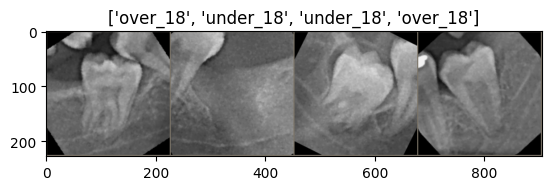

In [112]:
# show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [113]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = {'train': {'loss': [], 'acc': []}, 'val': {'loss': [], 'acc': []}}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                history[phase]['loss'].append(epoch_loss)
                # acc is a tensor, so we need to convert it to a float
                history[phase]['acc'].append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, history

In [114]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [115]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [116]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

Epoch 0/59
----------
train Loss: 0.7803 Acc: 0.6042
val Loss: 0.8118 Acc: 0.6737

Epoch 1/59
----------
train Loss: 0.7419 Acc: 0.6201
val Loss: 0.7653 Acc: 0.6842

Epoch 2/59
----------
train Loss: 0.7639 Acc: 0.6807
val Loss: 1.3496 Acc: 0.4947

Epoch 3/59
----------
train Loss: 0.7878 Acc: 0.6438
val Loss: 1.4900 Acc: 0.4737

Epoch 4/59
----------
train Loss: 0.6179 Acc: 0.7361
val Loss: 0.5296 Acc: 0.7789

Epoch 5/59
----------
train Loss: 0.7182 Acc: 0.6992
val Loss: 0.6318 Acc: 0.7474

Epoch 6/59
----------
train Loss: 0.7202 Acc: 0.7282
val Loss: 0.6880 Acc: 0.6737

Epoch 7/59
----------
train Loss: 0.3711 Acc: 0.8417
val Loss: 0.5384 Acc: 0.8316

Epoch 8/59
----------
train Loss: 0.3526 Acc: 0.8470
val Loss: 0.4985 Acc: 0.7895

Epoch 9/59
----------
train Loss: 0.3374 Acc: 0.8628
val Loss: 0.4609 Acc: 0.8105

Epoch 10/59
----------
train Loss: 0.3770 Acc: 0.8232
val Loss: 0.5003 Acc: 0.7895

Epoch 11/59
----------
train Loss: 0.3697 Acc: 0.8443
val Loss: 0.4393 Acc: 0.8316

Ep

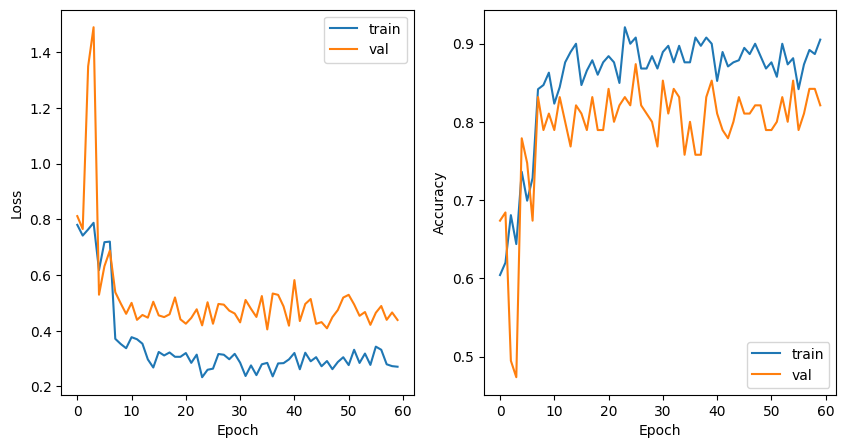

In [117]:
# plot training history in two subplots, one for loss and one for accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ft['train']['loss'], label='train')
plt.plot(history_ft['val']['loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft['train']['acc'], label='train')
plt.plot(history_ft['val']['acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()